In [1]:
%matplotlib inline

import os
import sys
import pathlib
import h5py
import numpy as np
import pandas as pd
import scipy.io as sio
from sklearn import decomposition
from module_tools import plotting_functions

from numpy import inf
from matplotlib.ticker import FormatStrFormatter
from matplotlib import gridspec
from matplotlib import ticker

import matplotlib.pyplot as plt

np.set_printoptions(linewidth=300, precision=3)

### Supporting functions

In [19]:
def train_pca_nd(training_data, data_df, num_components=3):
    pca_nd = decomposition.PCA(n_components=num_components)
    pca_nd_result = pca_nd.fit_transform(training_data)
    #print('{}D PCA explained variance: '.format(num_components), pca_nd.explained_variance_ratio_)
    
    # Adding pca components to dataframe
    for i in range(num_components):
        new_column = 'pca-{}'.format(i+1)
        data_df[new_column] = np.nan
        data_df.loc[~data_df['errored'], new_column] = pca_nd_result[:,i]
    
    return pca_nd, data_df

def apply_pca_nd(pca_obj, test_data, test_data_df):
    pca_apply_result = pca_obj.transform(test_data)
    num_components = pca_obj.n_components_

    for i in range(num_components):
        new_column = 'pca-{}'.format(i+1)
        test_data_df[new_column] = np.nan
        if 'errored' in test_data_df.columns:
            test_data_df.loc[~test_data_df['errored'], new_column] = pca_apply_result[:,i]
        else:
            test_data_df.loc[:, new_column] = pca_apply_result[:,i]
    
    return test_data_df

### Generating needed data

In [24]:
# Selecting trial folders
trial_folders = ['Trial_0009-py',]

# Loading analysis data and combining into single DF
analysis_data_df = pd.read_hdf("DATA/Trial_0009_analysis.h5", key='/param_set_outputs_df')
#print(analysis_data_df['prob2d_vector'][~analysis_data_df['errored']])
expdat_df = pd.read_hdf("DATA/expdata_output.h5", key='/expdata_df')
print(expdat_df['gene_pair'])

0     [gata5, pax8]
1     [gata5, pax8]
2     [gata5, pax8]
3     [gata5, pax8]
4     [gata5, pax8]
5     [gata5, pax8]
6     [gata5, pax8]
7     [gata5, pax8]
8     [gata5, pax8]
9     [gata5, pax8]
10        [sox2, t]
11        [sox2, t]
12        [sox2, t]
13        [sox2, t]
14        [sox2, t]
15        [sox2, t]
16        [sox2, t]
17        [sox2, t]
18        [sox2, t]
19        [sox2, t]
20     [lhx1, pax8]
21     [lhx1, pax8]
22     [lhx1, pax8]
23     [lhx1, pax8]
24     [lhx1, pax8]
25     [lhx1, pax8]
26     [lhx1, pax8]
27     [lhx1, pax8]
28     [lhx1, pax8]
29     [lhx1, pax8]
Name: gene_pair, dtype: object


In [17]:
# Simdat PCA 2D on log data
p_thresh = 1e-6

training_data_raw = np.array([i for i in analysis_data_df['prob2d_vector'][~analysis_data_df['errored']].values])
training_data_raw[training_data_raw<p_thresh]=p_thresh
print(training_data_raw.shape)
training_data = -np.log(training_data_raw)
pca_2d_obj, pca_data_df_2d = train_pca_nd(training_data, analysis_data_df, num_components=2)

(19882, 441)


In [7]:
df = pca_data_df_2d[~pca_data_df_2d['errored']]

testing_data_raw = np.array([i for i in expdat_df['prob2d_vector'].values])
testing_data_raw[testing_data_raw<p_thresh]=p_thresh
testing_data = -np.log(testing_data_raw)

pca_expdat_df_2d = apply_pca_nd(pca_2d_obj, testing_data, expdat_df)

In [8]:
# Simdat PCA 10D on log data
p_thresh = 1e-6

training_data_raw = np.array([i for i in analysis_data_df['prob2d_vector'][~analysis_data_df['errored']].values])
training_data_raw[training_data_raw<p_thresh]=p_thresh
training_data = -np.log(training_data_raw)

pca_nd_obj, pca_data_df_nd = train_pca_nd(training_data, analysis_data_df, num_components=10)

In [18]:
df = pca_data_df_nd[~pca_data_df_nd['errored']]

testing_data_raw = np.array([i for i in expdat_df['prob2d_vector'].values])
testing_data_raw[testing_data_raw<p_thresh]=p_thresh
testing_data = -np.log(testing_data_raw)

pca_expdat_df_nd = apply_pca_nd(pca_nd_obj, testing_data, expdat_df)

ValueError: Expected 2D array, got 1D array instead:
array=[-0.    -0.    -0.    -0.    -0.    -0.    -0.    -0.    -0.    -0.    -0.693 -0.693 -0.693 -0.693 -0.693 -0.693 -0.693 -0.693 -0.693 -0.693 -1.099 -1.099 -1.099 -1.099 -1.099 -1.099 -1.099 -1.099 -1.099 -1.099].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

### Plotting and marking representative regions

In [12]:
sets_to_plot = {'A': [1396,], 'B': [16038,], 'C': [22305,], 'D': [10433,], 'E': [21378,], 'F': [19395,]}

##### Notes: May need to match colorbar directions, 2 options/methods for plotting?

In [10]:
# Plotting all regions
trial_path = os.path.join('/', 'Users', 'camerongallivan', 'Research_Data', 'Simulation_Data', 
                          'Trial_0009-py', 'simulation_data.h5')
axisLabels = ['Counts per cell - B', 'Counts per cell - A']
pset_template = 'set_{:05d}'

trialDataFile = h5py.File(trial_path, "r")
for region in sets_to_plot.keys():
    print(region, end=', ')
    for pset in sets_to_plot[region]:
        pset_format = pset_template.format(pset)
        print(pset_format)
        prob2d = np.array(trialDataFile['Prob2D/'+pset_format])
        prob2d[prob2d<1e-6] = 1e-6

        title='Quasipotential'
        q_potential = -np.log(np.abs(prob2d))
        output_path = 'figure_outputs/PCA_2D_regions/Quasipotential_region_{}_{}.png'.format(region, pset_format)
        plotting_functions.plot_2d_heatmap_nb(q_potential, axis_labels=axisLabels, invert_color = True, show_fig=False, limits=(3,14),
                                              save_fig=True, fig_name=output_path, show_colorbar=True, square_axis=True, title=title)

trialDataFile.close()

A, set_01396
B, set_16038
C, set_22305
D, set_10433
E, set_21378
F, set_19395


set_20268


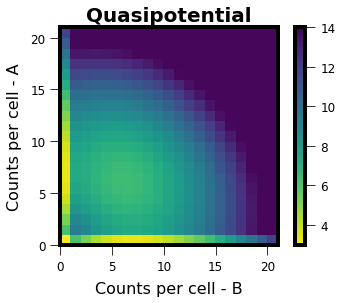

In [19]:
# Plotting all regions
trial_path = os.path.join('/', 'Users', 'camerongallivan', 'Research_Data', 'Simulation_Data', 
                          'Trial_0009-py', 'simulation_data.h5')
axisLabels = ['Counts per cell - B', 'Counts per cell - A']
pset_template = 'set_{:05d}'
pset = 20268

trialDataFile = h5py.File(trial_path, "r")
pset_format = pset_template.format(pset)
print(pset_format)
prob2d = np.array(trialDataFile['Prob2D/'+pset_format])
prob2d[prob2d<1e-6] = 1e-6

title='Quasipotential'
q_potential = -np.log(np.abs(prob2d))
plotting_functions.plot_2d_heatmap_nb(q_potential, axis_labels=axisLabels, invert_color = True, show_fig=True, limits=(3,14),
                                      save_fig=False, show_colorbar=True, square_axis=True, title=title)

trialDataFile.close()

### PCA Marked plotting

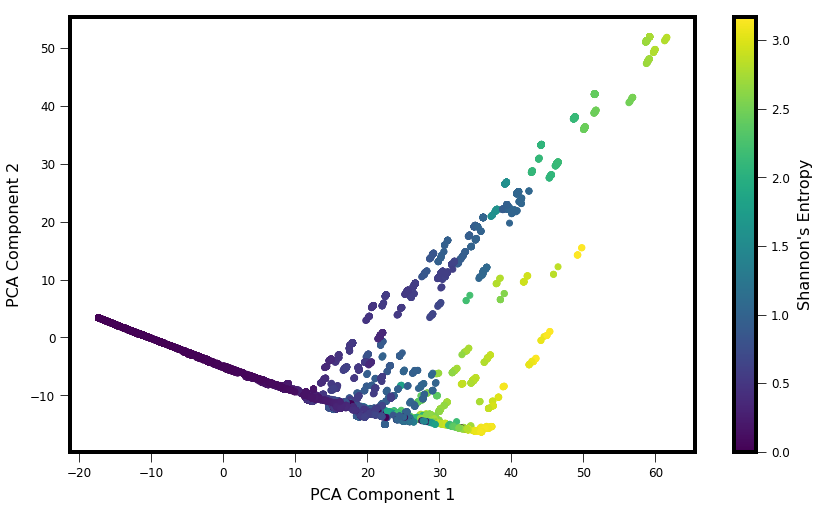

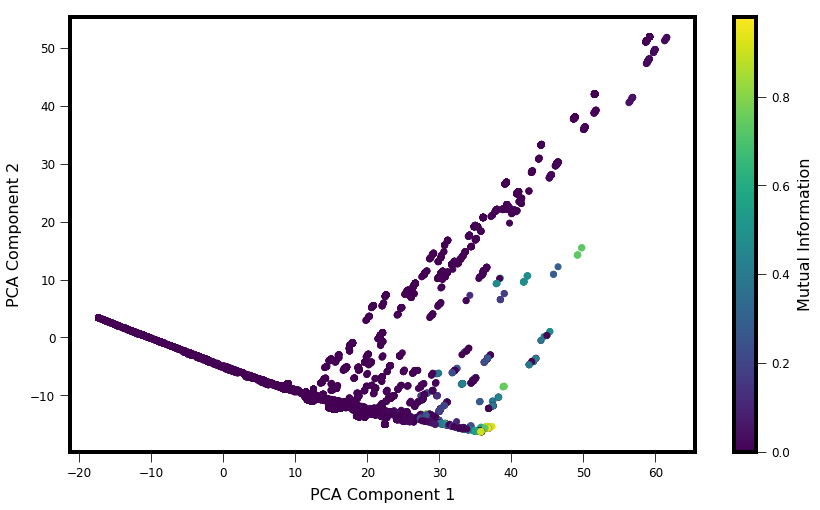

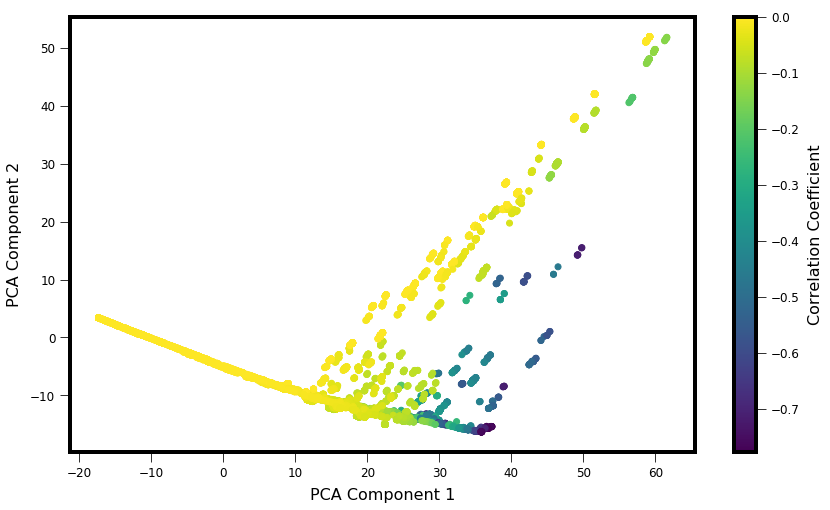

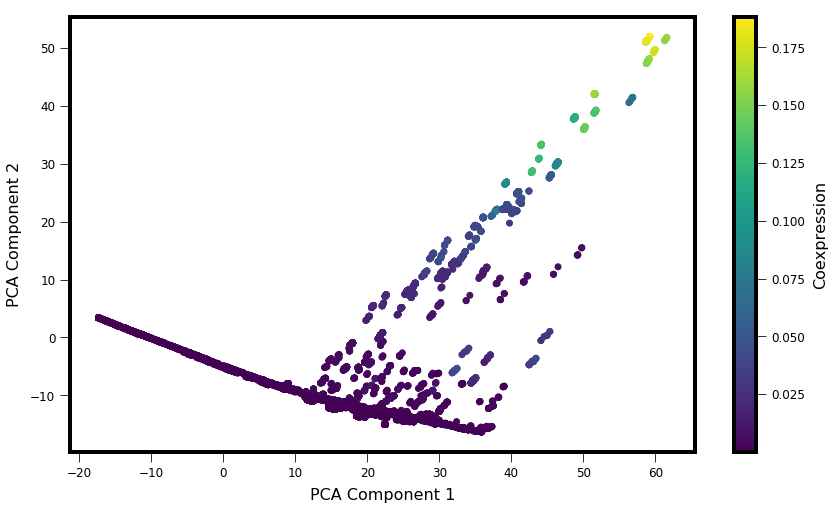

In [15]:
df = pca_data_df_2d[~pca_data_df_2d['errored']]
output_path = 'figure_outputs/PCA_2D_Entropy.png'
plotting_functions.plot_2d_pca_df(df, color_column='prob2d_entropy', save_fig=True, fig_name=output_path, cbar_label="Shannon's Entropy")

output_path = 'figure_outputs/PCA_2D_MutInfo.png'
plotting_functions.plot_2d_pca_df(df, color_column='mutual_information', save_fig=True, fig_name=output_path, cbar_label="Mutual Information")

output_path = 'figure_outputs/PCA_2D_CorCoef.png'
plotting_functions.plot_2d_pca_df(df, color_column='correl_coefficient', save_fig=True, fig_name=output_path, cbar_label="Correlation Coefficient")

output_path = 'figure_outputs/PCA_2D_Coex.png'
plotting_functions.plot_2d_pca_df(df, color_column='coexpression', save_fig=True, fig_name=output_path, cbar_label="Coexpression")

KeyError: 'trialParamSetNum'

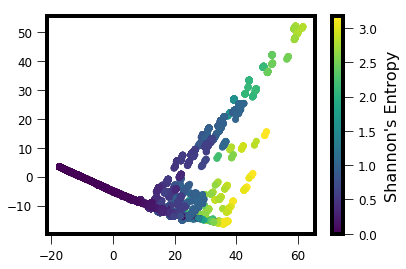

In [16]:
df = pca_data_df_2d[~pca_data_df_2d['errored']]
output_path = 'figure_outputs/PCA_2D_regions/PCA_2D_marked_regions.png'
plotting_functions.plot_2d_pca_df_marked(df, sets_to_plot, color_column='prob2d_entropy', save_fig=True, fig_name=output_path, cbar_label="Shannon's Entropy")

### Plotting PCA component shapes

In [ ]:
keep_comp = 10
covar_array = pca_nd_obj.components_
for i in range(keep_comp):
    current_component = covar_array[i,:]
    reshaped_component = current_component.reshape((21,21))
    output_path = 'figure_outputs/PCA_component_shapes/pca_component_{}.png'
    plotting_functions.plot_2d_heatmap_nb(reshaped_component, axis_labels=None, square_axis=True, 
                                          invert_color = False, show_fig=True, show_colorbar=True, limits=(-0.1, .1), 
                                          save_fig=True, fig_name=output_path.format(i+1), colorbar_tick_format='%.2f', cmap='bwr')

### Plotting PCA component shapes subplots

In [166]:
def rcparam():
    plt.rc('axes', linewidth=4.0, labelsize=16, labelpad=8)
    plt.rc('xtick.major', size=10, pad=5)  # length for x tick and padding
    plt.rc('ytick.major', size=10, pad=5)  # length for y tick and padding
    plt.rc('lines', mew=5, lw=4) # line 'marker edge width' and thickness
    plt.rc('ytick', labelsize=12)  # ytick label size
    plt.rc('xtick', labelsize=12)  # xtick label size

def component_shape_subplots(array_list, title=None, axis_labels=None, save_fig=False, fig_name=None, force_ticks=True, 
                             axis_tick_format='%.0f', **kwargs):
    rcparam()
    plot_count = len(array_list)
    fig, axes = plt.subplots(ncols=1, nrows=plot_count)

    # Setting cmap
    if kwargs.get('cmap', False):
        plt.set_cmap(kwargs['cmap'])
    
    # Plotting within defined limits
    for i, ax in enumerate(axes):
        if 'absolute_max' in kwargs:
            cax = ax.pcolormesh(array_list[i], vmin=0., vmax=kwargs['absolute_max'])
        elif 'limits' in kwargs:
            cax = ax.pcolormesh(array_list[i], vmin=kwargs['limits'][0], vmax=kwargs['limits'][1])
        else:
            cax = ax.pcolormesh(array_list[i])

        # Building colorbar
        if kwargs.get('show_colorbar', False):
            if kwargs.get('colorbar_tick_format', False):
                cbar = fig.colorbar(cax, format=kwargs['colorbar_tick_format'], ax=ax, pad=0.03)
            else:
                cbar = fig.colorbar(cax, ax=ax, pad=0.03)

        # Formatting and reshaping axes
        ax.xaxis.set_major_formatter(FormatStrFormatter(axis_tick_format))
        ax.yaxis.set_major_formatter(FormatStrFormatter(axis_tick_format))
        if axis_labels:
            ax.set(xlabel=axis_labels[0], ylabel=axis_labels[1])
        if force_ticks:
            xticks = ax.get_xticks()[0:-1]
            ax.set_yticks(xticks)
        if kwargs.get('square_axis', False):
            ax.set_aspect('equal', 'box')
        ax.set(ylabel='PCA Comp {}'.format(i + 1))
        
    # Aspect Ratio/sizing
    if 'fig_shape' in kwargs.keys():
        fig.set_size_inches(kwargs['fig_shape'])
    else:
        fig.set_size_inches((plot_count*2, plot_count*4+5))

    if title:
        plt.title(title, fontsize=20, weight='bold', y=1.02)

    if save_fig and fig_name is not None:
        plt.savefig(fig_name, transparent=True, bbox_inches='tight', pad_inches=0.1, format='png')
    #plt.close()
    plt.show()

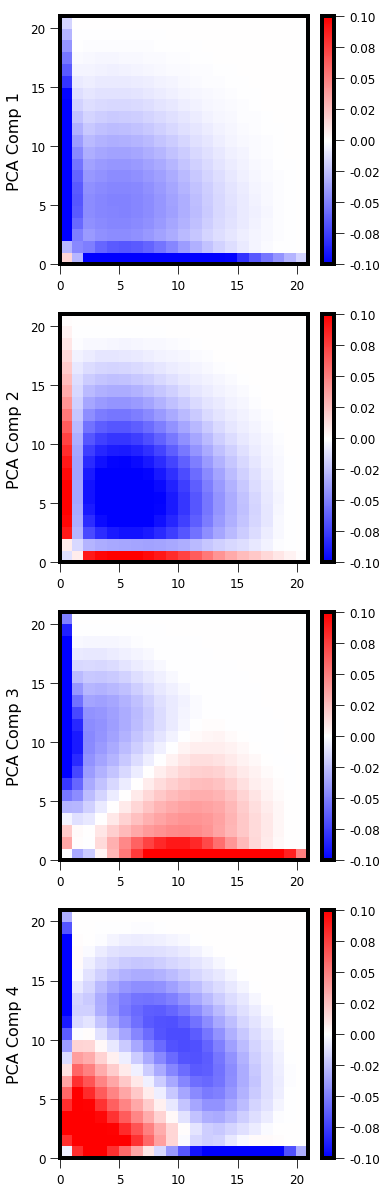

In [167]:
keep_comp = 4
covar_array = pca_nd_obj.components_

arrays_to_plot = []
for i in range(keep_comp):
    current_component = covar_array[i,:]
    reshaped_component = current_component.reshape((21,21))
    arrays_to_plot.append(reshaped_component)
    
component_shape_subplots(arrays_to_plot, square_axis=True, show_colorbar=True, limits=(-0.1, .1),
                         save_fig=False, fig_name=None, colorbar_tick_format='%.2f', cmap='bwr')

### PCA component vs stage subplot 

In [61]:
#  Retraining data just in case
p_thresh = 1e-6

training_data_raw = np.array([i for i in analysis_data_df['prob2d_vector'][~analysis_data_df['errored']].values])
training_data_raw[training_data_raw<p_thresh]=p_thresh
training_data = -np.log(training_data_raw)

pca_nd_obj, pca_data_df_nd = train_pca_nd(training_data, analysis_data_df, num_components=10)

# Applying to expdat again
df = pca_data_df_nd[~pca_data_df_nd['errored']]

testing_data_raw = np.array([i for i in expdat_df['prob2d_vector'].values])
testing_data_raw[testing_data_raw<p_thresh]=p_thresh
testing_data = -np.log(testing_data_raw)

pca_expdat_df_nd = apply_pca_nd(pca_nd_obj, testing_data, expdat_df)
pca_expdat_df_nd = pca_expdat_df_nd.sort_values(by=['gene_pair_num', 'development_stage'])
df_subset_1 = pca_expdat_df_nd[pca_expdat_df_nd['gene_pair_num']==7]
df_subset_2 = pca_expdat_df_nd[pca_expdat_df_nd['gene_pair_num']==9]

In [133]:
def component_subplots(df1, df2, pca_components=4, title=None, save_fig=False, fig_name=None, **kwargs):
    #rcparam()
    fig, axes = plt.subplots(ncols=1, nrows=pca_components, gridspec_kw={"hspace": 0.35})

    # Figure Creation
    for i, ax in enumerate(axes):
        # Plotting df1
        x_1 = df1['development_stage']
        y_1 = df1['pca-{}'.format(i + 1)]
        gene_pair_1 = '-'.join(df1['gene_pair'].iloc[0])
        ax.plot(x_1, y_1, '.-', label=gene_pair_1)

        # Plotting df2
        x_2 = df2['development_stage']
        y_2 = df2['pca-{}'.format(i + 1)]
        gene_pair_2 = '-'.join(df2['gene_pair'].iloc[0])
        ax.plot(x_2, y_2, '.-', label=gene_pair_2)

        # Formatting
        ax.margins(0.05, 0.15)
        ax.set(ylabel='PCA Comp {}'.format(i + 1))
        ax.get_yaxis().set_label_coords(-0.14, 0.5)
        ax.grid(True)

    # Aspect Ratio/sizing
    if 'fig_shape' in kwargs.keys():
        fig.set_size_inches(kwargs['fig_shape'])
    else:
        fig.set_size_inches((pca_components + 2, pca_components * 2 + 2))

    # Legend and labels
    axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    axes[-1].set(xlabel='Development Stage')

    if title:
        plt.title(title, fontsize=20, weight='bold', y=1.02)

    if save_fig and fig_name is not None:
        plt.savefig(fig_name, transparent=True, bbox_inches='tight', pad_inches=0.1, format='png')

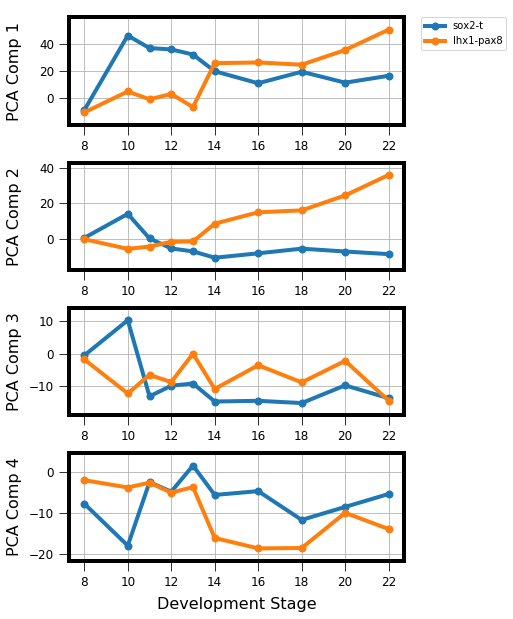

In [134]:
component_subplots(df_subset_1, df_subset_2)

### PCA component vs stage

In [15]:
#  Retraining data just in case
p_thresh = 1e-6

training_data_raw = np.array([i for i in analysis_data_df['prob2d_vector'][~analysis_data_df['errored']].values])
training_data_raw[training_data_raw<p_thresh]=p_thresh
training_data = -np.log(training_data_raw)

pca_nd_obj, pca_data_df_nd = train_pca_nd(training_data, analysis_data_df, num_components=10)

# Applying to expdat again
df = pca_data_df_nd[~pca_data_df_nd['errored']]

testing_data_raw = np.array([i for i in expdat_df['prob2d_vector'].values])
testing_data_raw[testing_data_raw<p_thresh]=p_thresh
testing_data = -np.log(testing_data_raw)

pca_expdat_df_nd = apply_pca_nd(pca_nd_obj, testing_data, expdat_df)

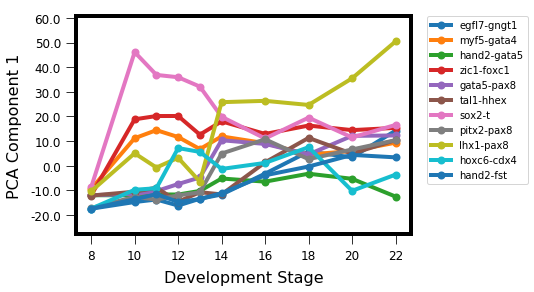

In [30]:
pca_expdat_df_tmp = pca_expdat_df_nd.sort_values(by=['gene_pair_num', 'development_stage'])
component_columns = ['pca-{}'.format(i+1) for i in range(pca_nd_obj.n_components_)]

for i, component_column in enumerate(component_columns):
    y_label = 'PCA Component {}'.format(i+1)
    output_path = 'figure_outputs/PCA_expdat_components/pca_component_{}.png'.format(i+1)
    plotting_functions.component_plot(pca_expdat_df_tmp, component_column, x_label='Development Stage', y_label=y_label, save_fig=True, fig_name=output_path)
    #break

### 2D PCA plots and methods with expdat trajectory overlay

In [18]:
def plot_2d_pca_df_exp(data_df_1, data_df_2, color_column_1=None, color_column_2=None, save_fig=False, fig_name=None, discrete=False, **kwargs):   
    # 2D plotting the components
    '''
        Setting unify_cbar to True in the arguments creates a "dual-scaled" colorbar, left corresponds to data_df_1[color_column_1], right to data_df_2[color_column_2]
        Setting this to false or leaving it undeclared (provided both color columns are defined) defaults to setting the colorbar to the overall max of the color values
    '''
    if (color_column_1 is not None) or (color_column_2 is not None):
        fig, (ax, cax) = plt.subplots(ncols=2, gridspec_kw={"width_ratios":[25,1], "wspace":0.1})
    else:
        fig, ax = plt.subplots()
    plt.set_cmap('viridis')    
        
    # Getting data maxes for colorscales
    if kwargs.get('data_max', False):
        all_data_max = kwargs['data_max']
    else:
        if color_column_1 is not None:
            data_1_max = np.nanmax(data_df_1[color_column_1].values)
        if color_column_2 is not None:
            data_2_max = np.nanmax(data_df_2[color_column_2].values)
        if (color_column_1 is not None) and (color_column_2 is not None):
            all_data_max = np.max([data_1_max, data_2_max])

    # Plotting simdat
    p = ax.scatter(data_df_1['pca-1'].values, data_df_1['pca-2'].values, c=data_df_1[color_column_1].values, vmax=all_data_max)
    cbar = plt.colorbar(p, cax=cax)
    cbar.set_label(kwargs.get('cbar_label', color_column_1))
    
    # Plotting expdat trajectory
    t = ax.plot(data_df_2['pca-1'].values, data_df_2['pca-2'].values, '-', c='orangered')
    s = ax.scatter(data_df_2['pca-1'].values, data_df_2['pca-2'].values, c=data_df_2[color_column_2].values, marker='X', 
                   edgecolors='w', s=140, vmax=all_data_max, zorder=3)
         
    # Labeling expdat
    if 'exp_point_label_column' in kwargs.keys():    
        point_labels = data_df_2[kwargs['exp_point_label_column']].values
        for i, txt in enumerate(point_labels):
            ax.annotate(txt, (data_df_2['pca-1'].values[i], data_df_2['pca-2'].values[i]), xytext=(7, 7), textcoords='offset pixels')
    
    # Formatting plot
    ax.set_xlabel('PCA Component 1')
    ax.set_ylabel('PCA Component 2')
    
    if 'fig_shape' in kwargs.keys():
        fig.set_size_inches(kwargs['figshape'])
    else:
        fig.set_size_inches((14, 8))
        
    if 'title' in kwargs.keys():
        ax.set_title(kwargs['title'])
    
    # Saving and showing plot
    if save_fig and fig_name is not None:
        plt.savefig(fig_name, transparent=True, bbox_inches='tight', pad_inches=0.1, format='png')
    plt.show()

 Gene pair: gata5-pax8


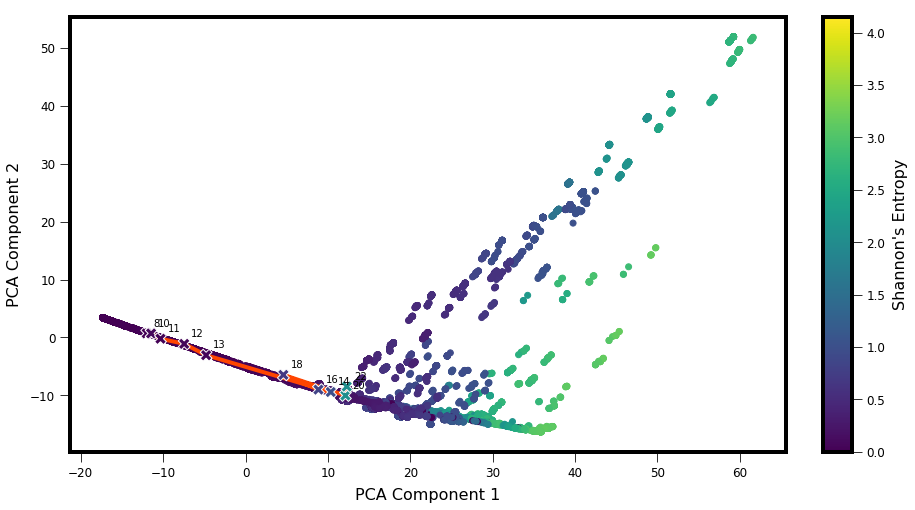

 Gene pair: sox2-t


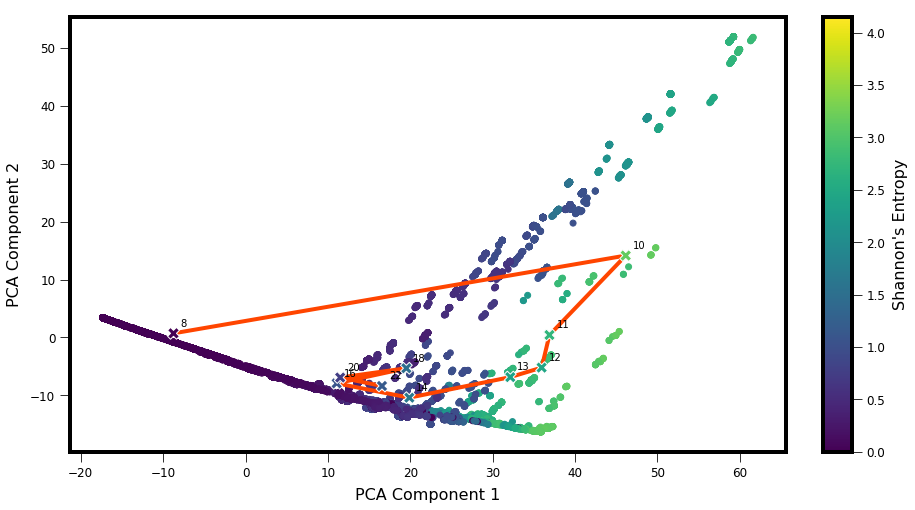

 Gene pair: lhx1-pax8


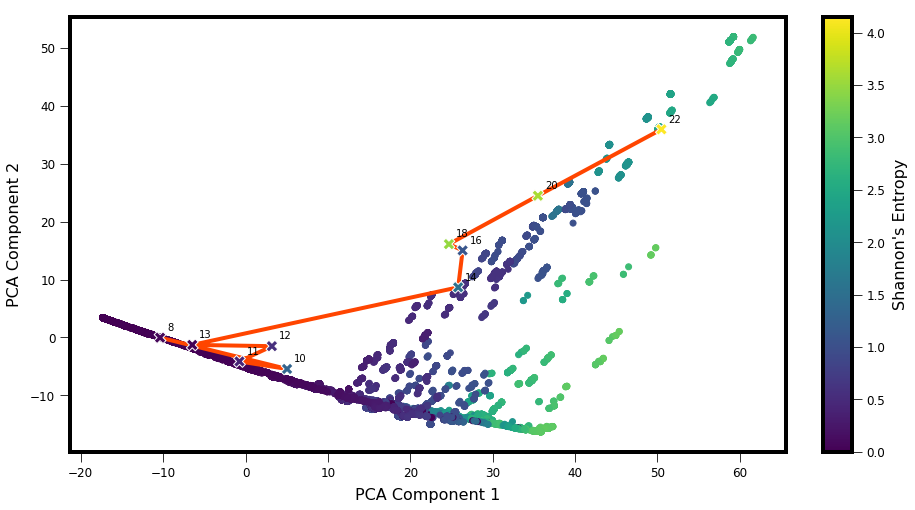

In [36]:
# Plotting subset of gene pairs
df = pca_data_df_2d[~pca_data_df_2d['errored']]
pca_expdat_df_2d_sorted = pca_expdat_df_2d.sort_values(by=['gene_pair_num', 'development_stage'])

plot_title=None
#pca_expdat_df_2d_subset = pca_expdat_df_2d_sorted[pca_expdat_df_2d_sorted['gene_pair_num'].isin([1, 2, 3])]
pca_expdat_df_2d_subset = pca_expdat_df_2d_sorted
data_max = pca_expdat_df_2d_subset['prob2d_entropy'].max()

#plot_title = 'PCA Trained on all non-errored data with gene pair: ' + '-'.join(pca_expdat_df_tmp.iloc[0]['gene_pair'])
for gene_pair_num in np.unique(pca_expdat_df_2d_subset['gene_pair_num']):
    df_tmp = pca_expdat_df_2d_subset[pca_expdat_df_2d_subset['gene_pair_num']==gene_pair_num]
    dat = df_tmp[['pca-1','pca-2']]
    exp_fp = "DATA/%s.csv" % '_'.join(df_tmp.iloc[0]['gene_pair'])
    dat.to_csv(exp_fp, index=False)
    print(' Gene pair:', '-'.join(df_tmp.iloc[0]['gene_pair']))
    output_path = 'figure_outputs/PCA_expdat_development_trajectory/pca_expdat_seperate_2_{}.png'.format('-'.join(df_tmp.iloc[0]['gene_pair']))
    plot_2d_pca_df_exp(df, df_tmp, color_column_1='prob2d_entropy', color_column_2='prob2d_entropy', cbar_label="Shannon's Entropy", data_max=data_max,
                                                  exp_point_label_column='development_stage', title=plot_title, save_fig=True, fig_name=output_path)

In [21]:
def plot_2d_pca_df_multiexp(data_df_1, data_df_2, color_column_1=None, color_column_2=None, save_fig=False, fig_name=None, discrete=False, **kwargs):   
    # 2D plotting the components
    '''
        Setting unify_cbar to True in the arguments creates a "dual-scaled" colorbar, left corresponds to data_df_1[color_column_1], right to data_df_2[color_column_2]
        Setting this to false or leaving it undeclared (provided both color columns are defined) defaults to setting the colorbar to the overall max of the color values
    '''
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    if (color_column_1 is not None) or (color_column_2 is not None):
        fig, (ax, cax) = plt.subplots(ncols=2, gridspec_kw={"width_ratios":[25,1], "wspace":0.1})
    else:
        fig, ax = plt.subplots()
    plt.set_cmap('viridis')
    
    # Getting data maxes for colorscales
    if color_column_1 is not None:
        data_1_max = np.nanmax(data_df_1[color_column_1].values)
    if color_column_2 is not None:
        data_2_max = np.nanmax(data_df_2[color_column_2].values)
    if (color_column_1 is not None) and (color_column_2 is not None):
        all_data_max = np.max([data_1_max, data_2_max])

    # Plotting simdat
    p = ax.scatter(data_df_1['pca-1'].values, data_df_1['pca-2'].values, c=data_df_1[color_column_1].values, vmax=all_data_max)
    cbar = plt.colorbar(p, cax=cax)
    cbar.set_label(kwargs.get('cbar_label', color_column_1))
    
    # Plotting expdat trajectory
    for i, gene_pair_num in enumerate(np.unique(data_df_2['gene_pair_num'])):
        x = data_df_2[data_df_2['gene_pair_num']==gene_pair_num]['pca-1']
        y = data_df_2[data_df_2['gene_pair_num']==gene_pair_num]['pca-2']
        z = data_df_2[data_df_2['gene_pair_num']==gene_pair_num][color_column_2].values
        gene_pair = '-'.join(data_df_2[data_df_2['gene_pair_num']==gene_pair_num]['gene_pair'].iloc[0])
        color=colors[i]
        t = ax.plot(x, y, '-',  c=color, label=gene_pair)
        s = ax.scatter(x, y, c=color, marker='o', s=200, vmax=all_data_max, zorder=3, label=None)
        #t = ax.plot(x, y, '-', label=gene_pair)
        #s = ax.scatter(x, y, marker='o', s=200, vmax=all_data_max, zorder=3, label=None)
        
        point_labels = data_df_2[data_df_2['gene_pair_num']==gene_pair_num]['development_stage'].values
        for i, txt in enumerate(point_labels):
            ax.annotate(txt, (x.values[i], y.values[i]), xytext=(-9,-5), textcoords='offset pixels')
    
    # Formatting plot
    ax.legend()
    ax.set_xlabel('PCA Component 1')
    ax.set_ylabel('PCA Component 2')
    
    if 'fig_shape' in kwargs.keys():
        fig.set_size_inches(kwargs['figshape'])
    else:
        fig.set_size_inches((14, 8))
        
    if 'title' in kwargs.keys():
        ax.set_title(kwargs['title'])
    
    # Saving and showing plot
    if save_fig and fig_name is not None:
        plt.savefig(fig_name, transparent=True, bbox_inches='tight', pad_inches=0.1, format='png')
    plt.show()

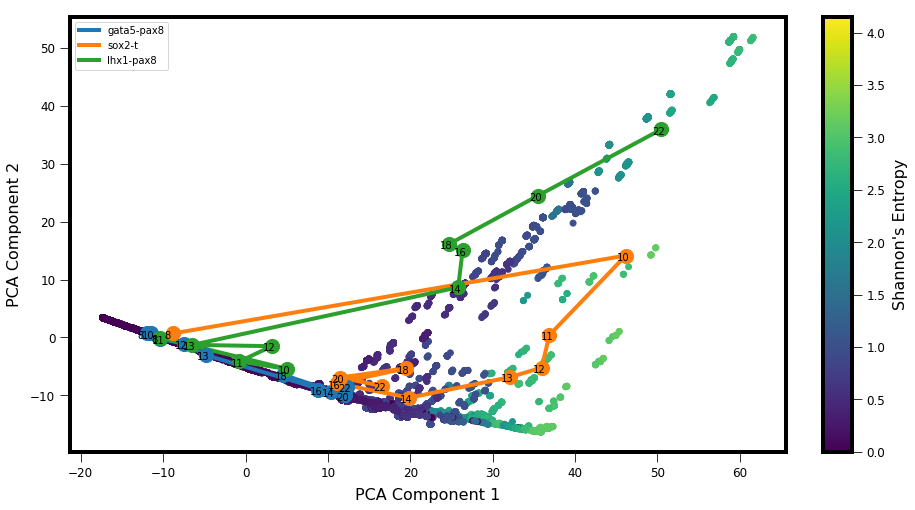

In [22]:
# Plotting subset of gene pairs
df = pca_data_df_2d[~pca_data_df_2d['errored']]
pca_expdat_df_2d_sorted = pca_expdat_df_2d.sort_values(by=['gene_pair_num', 'development_stage'])
pca_expdat_df_2d_subset = pca_expdat_df_2d_sorted[pca_expdat_df_2d_sorted['gene_pair_num'].isin([1, 2, 3])]

plot_title=None
output_path = 'figure_outputs/PCA_expdat_development_trajectory/pca_expdat_all_2.png'
plot_2d_pca_df_multiexp(df, pca_expdat_df_2d_subset, color_column_1='prob2d_entropy', color_column_2='prob2d_entropy', cbar_label="Shannon's Entropy",
                                              exp_point_label_column='development_stage', title=plot_title, save_fig=True, fig_name=output_path)

### Saving data and info for sharing

In [26]:
select_columns = ['trialParamSetNum', 'trial_num', 'model_name', 'N', 'g0', 'g1', 'g2', 'g3', 'g0_b', 'g1_b', 'g2_b', 'g3_b', 'fa', 'fr', 'ha', 'hr', 'kd', 'c_c', 'c_cr', 'c_o', 'logic_ID', 
       'mutual_information', 'prob2d_entropy', 'prob2d_error', 'correl_coefficient']
df2 = analysis_data_df[select_columns].set_index(analysis_data_df[select_columns].index+1)
df2.index.name = 'prob2D_row_index'

In [39]:
sio.savemat('simdat_prob2ds.mat', {'simdat_prob2ds': new_training_data}, do_compression=True)

In [10]:
prob2d_vec_array = np.array([row for row in analysis_data_df['prob2d_vector'].values])
sio.savemat('simdat_prob2ds.mat', {'simdat_prob2ds': prob2d_vec_array}, do_compression=True)
df2.to_csv('simdat_indexing.csv')

In [27]:
df2.to_csv('simdat_indexing.csv')